In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sp
import pycodamath as coda
from pycodamath import extra
import scipy.optimize as optimization

#### 1. Data Loading

In [161]:
import pandas as pd
import re

# Load data
data = pd.read_csv('../data/2-meteorites.csv', sep=',')
data.rename(columns={'Unnamed: 0': 'Location'}, inplace=True)

# Extract the part inside parentheses into 'Type'
data['Type'] = data['Location'].str.extract(r'\((.*?)\)')

# Remove the parentheses and content from 'Location'
data['Location'] = data['Location'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

# Reorder columns: Location, Type, then the rest
cols = ['Location', 'Type'] + [col for col in data.columns if col not in ['Location', 'Type']]
data = data[cols]

# Check result
print(data.head())
print(data.shape)


    Location Type   SiO2   Al2O3    FeO   MnO    MgO     Fe    Ni    Co     C
0    Allende   cc  34.23    3.27  27.15  0.18  24.62   0.17  0.36  0.01  0.29
1       Bali   cc  33.77    3.16  26.51  0.19  24.54   0.15  0.22  0.01  0.57
2  Efremovka   cc  34.31    3.37  17.20  0.19  24.71   5.51  1.37  0.06  0.76
3   Coolidge   cc  34.42    3.31   7.26  0.24  24.99   8.28  1.35  0.08  0.19
4    Ankober   hc  35.35    2.32  13.05  0.32  22.86  13.96  1.71  0.10  0.10
(12, 11)


#### 2. Visulisation

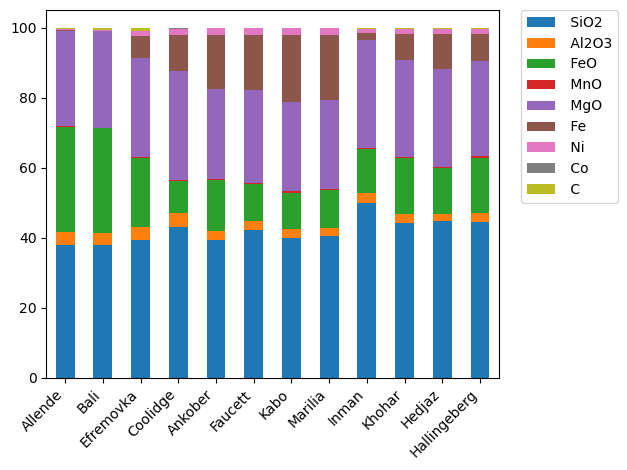

In [179]:
import matplotlib.pyplot as plt

# Apply coda closure
data.iloc[:, 2:] = data.iloc[:, 2:].coda.closure(100)

# Plot
ax = data.plot.bar(stacked=True)

# Set x-axis tick labels
ax.set_xticks(range(len(data.iloc[:, 0])))
ax.set_xticklabels(data.iloc[:, 0], rotation=45, ha='right')  # Rotate if needed

# Move legend outside
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.savefig('../handin/figures/stacked_bar.png', dpi=300, bbox_inches='tight')
plt.show()



we see that there is an obvious difference in the compositions of the meteorise fromt the 12 different origins
How obivius the cc/hc/ic groups overall effect on the compositions is not obious from this plot

#### 2.1 PCA

We have to first need to calculate the geometric means for each row of the closed data
$$
\mathbf{g} = (g_1, g_2, \dots, g_D), \quad \text{where} \quad g_j = \left( \prod_{i=1}^n x_{ij} \right)^{1/n}
$$

Variantion matrix

$$
t_{jk} = \frac{1}{n} \sum_{i=1}^n \left( \ln \frac{x_{ij}}{x_{ik}} - m_{jk} \right)^2
$$
$$
m_{jk} = \frac{1}{n} \sum_{i=1}^n \ln \frac{x_{ij}}{x_{ik}}
$$
Total varaince: 
$$
\text{TotVar}[T] = \frac{1}{2D} \sum_{i,j=1}^D t_{ij}
$$

Pertube the data by inverse of gm which
$$ data ⊕ gm$$
$$ data * \frac{1}{gm}$$
This equvilant to centereing the non compositional data.

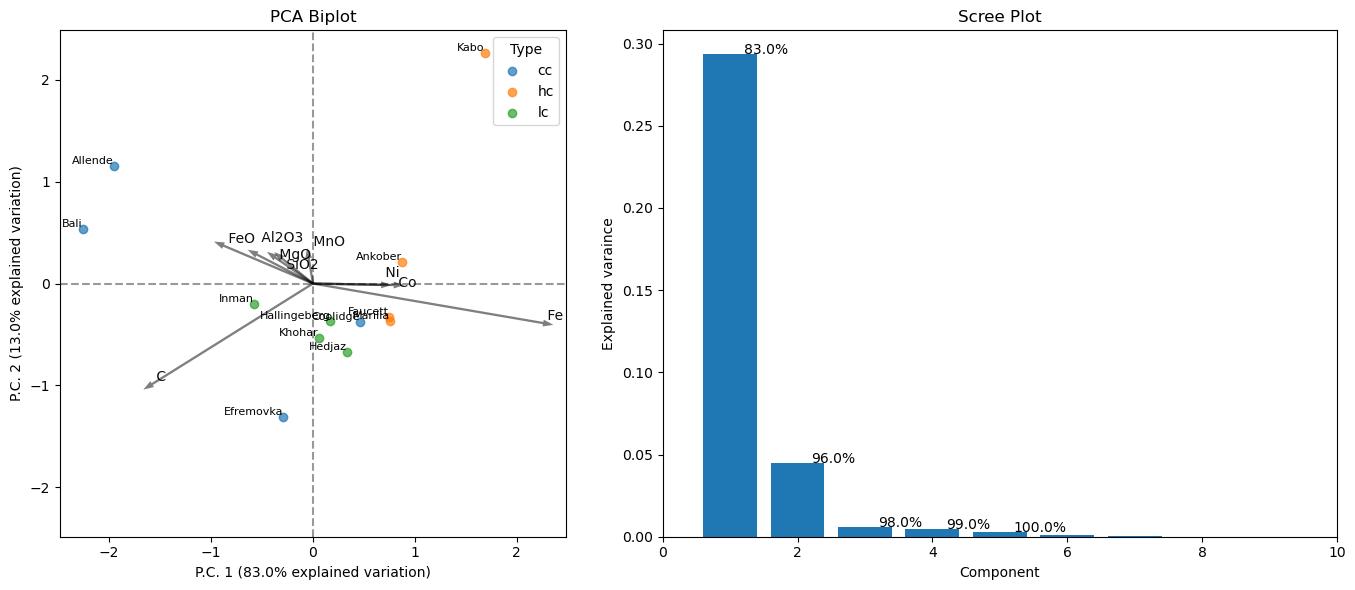

In [177]:
import matplotlib.pyplot as plt

# Define colors for each Type class
unique_types = data['Type'].unique()
color_map = {type_name: color for type_name, color in zip(unique_types, plt.cm.tab10.colors)}

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create the biplot object, telling it to use ax1
mypca = coda.pca.Biplot(data.iloc[:, 2:], axis=ax1, default=False)

# Plot on ax1 (we'll skip the default plotscores to control colors ourselves)
mypca.plotloadings()
mypca.adjustloadinglabels()
ax1.set_title('PCA Biplot')

# Plot points colored by Type
for type_name in unique_types:
    indices = data[data['Type'] == type_name].index
    samples = mypca.scores.columns[indices]
    x = [mypca.scores.loc['pc1', s] for s in samples]
    y = [mypca.scores.loc['pc2', s] for s in samples]
    ax1.scatter(x, y, color=color_map[type_name], label=type_name, alpha=0.7)

    # Annotate each point with location
    for i, s in zip(indices, samples):
        location_label = data.loc[i, 'Location']
        ax1.text(mypca.scores.loc['pc1', s], mypca.scores.loc['pc2', s],
                 str(location_label), fontsize=8, ha='right', va='bottom')

# Add legend
ax1.legend(title='Type')

# Run SVD and plot scree plot on ax2
scores, eig_val, loadings = coda.pca._svd(
    data.iloc[:, 2:].coda.center().coda.scale().coda.clr()
)
coda.pca.scree_plot(ax2, eig_val)
ax2.set_title('Scree Plot')

plt.tight_layout()
plt.savefig('../handin/figures/pca_biplot.png', dpi=300, bbox_inches='tight')
plt.show()